In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from skimage import io, color, exposure, filters

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import Adam

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.19.0


In [47]:
# Set parameters here 
INPUT_SIZE = 256 #324 try
BATCH_SIZE = 64

SEED = 12345
np.random.seed(SEED)

path = 'C:/Users/Gavela Maculuve/PycharmProjects/Ritcher/CS/Pneumonia'
trainpath = path + '/train'
testpath = path + '/test'
validpath = path + '/valid'
classes = ['BACTERIAL', 'NORMAL', 'VIRAL']

NUMCLASSES = len(classes)

In [49]:
def preprocess(img):
    # if len(img.shape)==2:
    #     img = np.mean(img, axis = 2)

    img = img - np.min(img)
    img = img / np.max(img)
    
    img = img - np.mean(img)
    img = img / np.std(img)   
    return img
# img = img - np.mean(img)
# std = np.std(img)
# img = img / (std + 1e-8)

In [51]:
img = io.imread(trainpath+'/BACTERIAL/person1_bacteria_1.jpeg')
gray = preprocess(img)
gray.shape

(439, 712, 3)

In [53]:
print("Train path exists:", os.path.exists(trainpath))
print("Train path:", trainpath)

Train path exists: True
Train path: C:/Users/Gavela Maculuve/PycharmProjects/Ritcher/CS/Pneumonia/train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9425033835196253..1.3152444552889726].


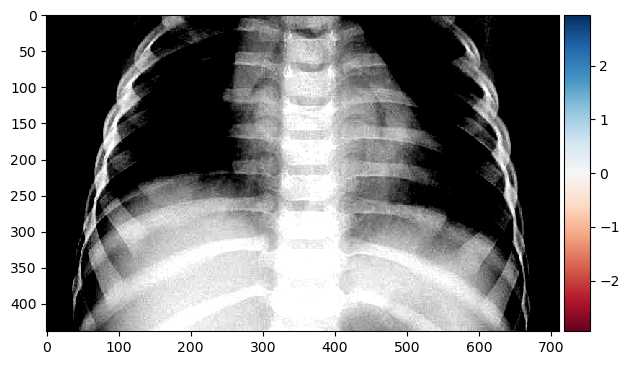

In [55]:
# gray = np.mean(img, axis=2)
io.imshow(gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9425033835196253..1.3152444552889726].


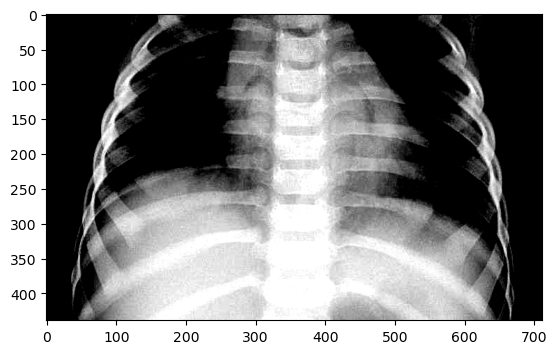

In [57]:
plt.imshow(gray, 'gray')

In [59]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=True,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [61]:
training_set = train_datagen.flow_from_directory(
                                            directory= trainpath,
                                            subset='training',
                                            target_size=(INPUT_SIZE,INPUT_SIZE),
                                            color_mode="grayscale",
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical",
                                            shuffle=True,
                                            seed=42
)

validation_set = train_datagen.flow_from_directory(
                                            directory= trainpath,
                                            subset='validation',
                                            target_size=(INPUT_SIZE,INPUT_SIZE),
                                            color_mode="grayscale",
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical",
                                            shuffle=True,
                                            seed=42
)

Found 3098 images belonging to 3 classes.
Found 773 images belonging to 3 classes.


In [63]:
#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Create a sequential model to add layers step by step
model = Sequential()

# Input layer that accepts grayscale images of shape
model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,1])) #keras will internally add batch dimension

#
model.add(Conv2D(filters=32,kernel_size=7,strides=2,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same')) # downsample the feature maps
model.add(Dropout(0.4))# Dropout layer to prevent overfitting by randomly turning off 40% of neurons

model.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

# Flatten the 2D feature maps into a 1D vector before feeding into dense layers
model.add(Flatten())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES,activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Gavela Maculuve\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
#Training
epochs = 10
history = model.fit(training_set,
               epochs=epochs,
               validation_data=validation_set)

model.save_weights("model-normalized-may-233.weights.h5")
print("Saved model to disk after",epochs,"epochs.")

C:\Users\Gavela Maculuve\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5883 - loss: 0.9900 - val_accuracy: 0.6585 - val_loss: 0.9023
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.7657 - loss: 0.6213 - val_accuracy: 0.8292 - val_loss: 0.6115
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8369 - loss: 0.5234 - val_accuracy: 0.8473 - val_loss: 0.5916
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8691 - loss: 0.4119 - val_accuracy: 0.8448 - val_loss: 0.5727
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8781 - loss: 0.3908 - val_accuracy: 0.8823 - val_loss: 0.4527
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8940 - loss: 0.3389 - val_accuracy: 0.7490 - val_loss: 0.6266
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8717 - loss: 0.3896 - val_accuracy: 0.8098 - val_loss: 0.5138
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8869 - loss: 0.3659 - val_accuracy: 0.8422 - val_loss:

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

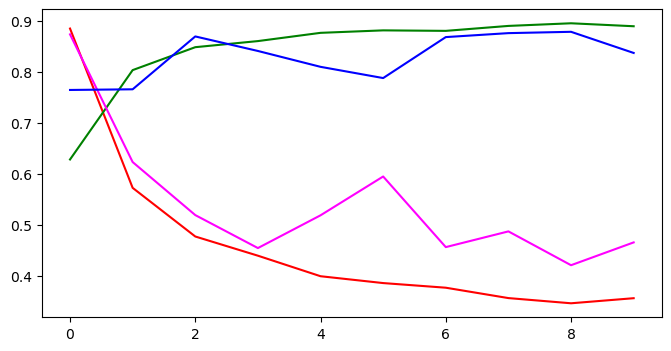

In [33]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Real class: VIRAL
Predictions:
BACTERIAL : 0.47520298
NORMAL : 0.30544037
VIRAL : 0.21935663


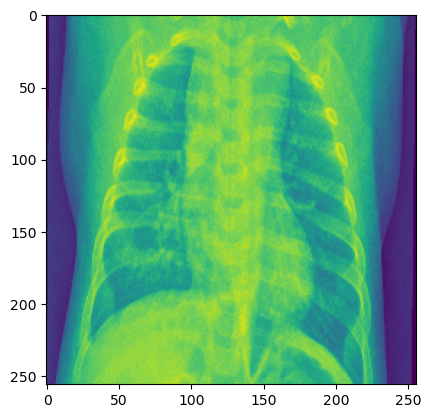

In [35]:
from skimage import io, transform, color, exposure
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = trainpath + '/' + classes[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))

while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))

image_path = folder + '/' + filelist[i]
img = io.imread(image_path)

# Prepare image
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img = preprocess(img)


plt.imshow(img)
# plt.plot(exposure.histogram(img)[0])
img_tensor = np.expand_dims(img, axis=(0, -1))

# Print what the top predicted class is
# print(img_tensor)
preds = model.predict(img_tensor)
preds = preds.flatten()
# print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]

reverse_class_labels = {v: k for k, v in training_set.class_indices.items()}
print('Real class:', classes[classnum])
print('Predictions:')
for i in range(3):
    if preds[order[i]] == 0:
        break
    else:
        print(reverse_class_labels[order[i]], ':', preds[order[i]])

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 854ms/step
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: NORMAL
Real class: BACTERIAL	Prediction: BACTERIAL
Real class: BACTE

array([506., 214.,  53.])

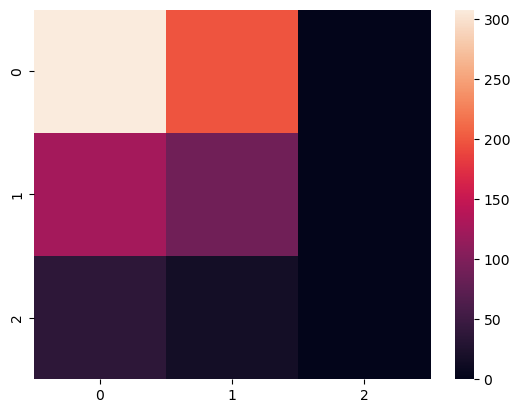

In [37]:
import seaborn as sn

testset = validation_set

predictions = model.predict(testset)

order = np.argsort(predictions)
conf = np.zeros([NUMCLASSES, NUMCLASSES])
count = 0

classcounts = np.zeros(NUMCLASSES)
for i in range(predictions.shape[0]):
    index = order[i,:]
    index = index[::-1]
    print('Real class:', reverse_class_labels[testset.labels[i]], end='\t')
    print('Prediction:',reverse_class_labels[index[0]])
    conf[testset.labels[i],index[0]] += 1
    classcounts[testset.labels[i]]+=1
    if testset.labels[i]==index[0]:
        count+=1
sn.heatmap(conf)
print(count)
classcounts    

<Axes: >

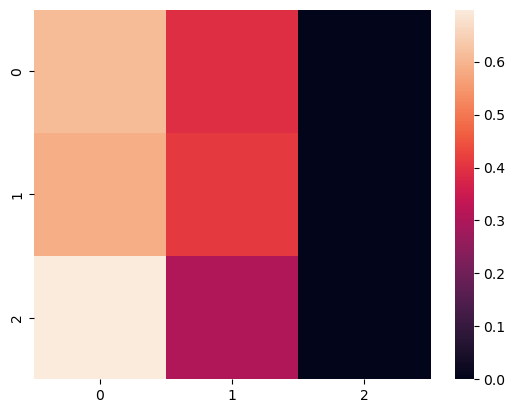

In [39]:
conf2 = np.copy(conf)
for i in range(conf2.shape[0]):
    conf2[i,:] /= classcounts[i]

sn.heatmap(conf2)

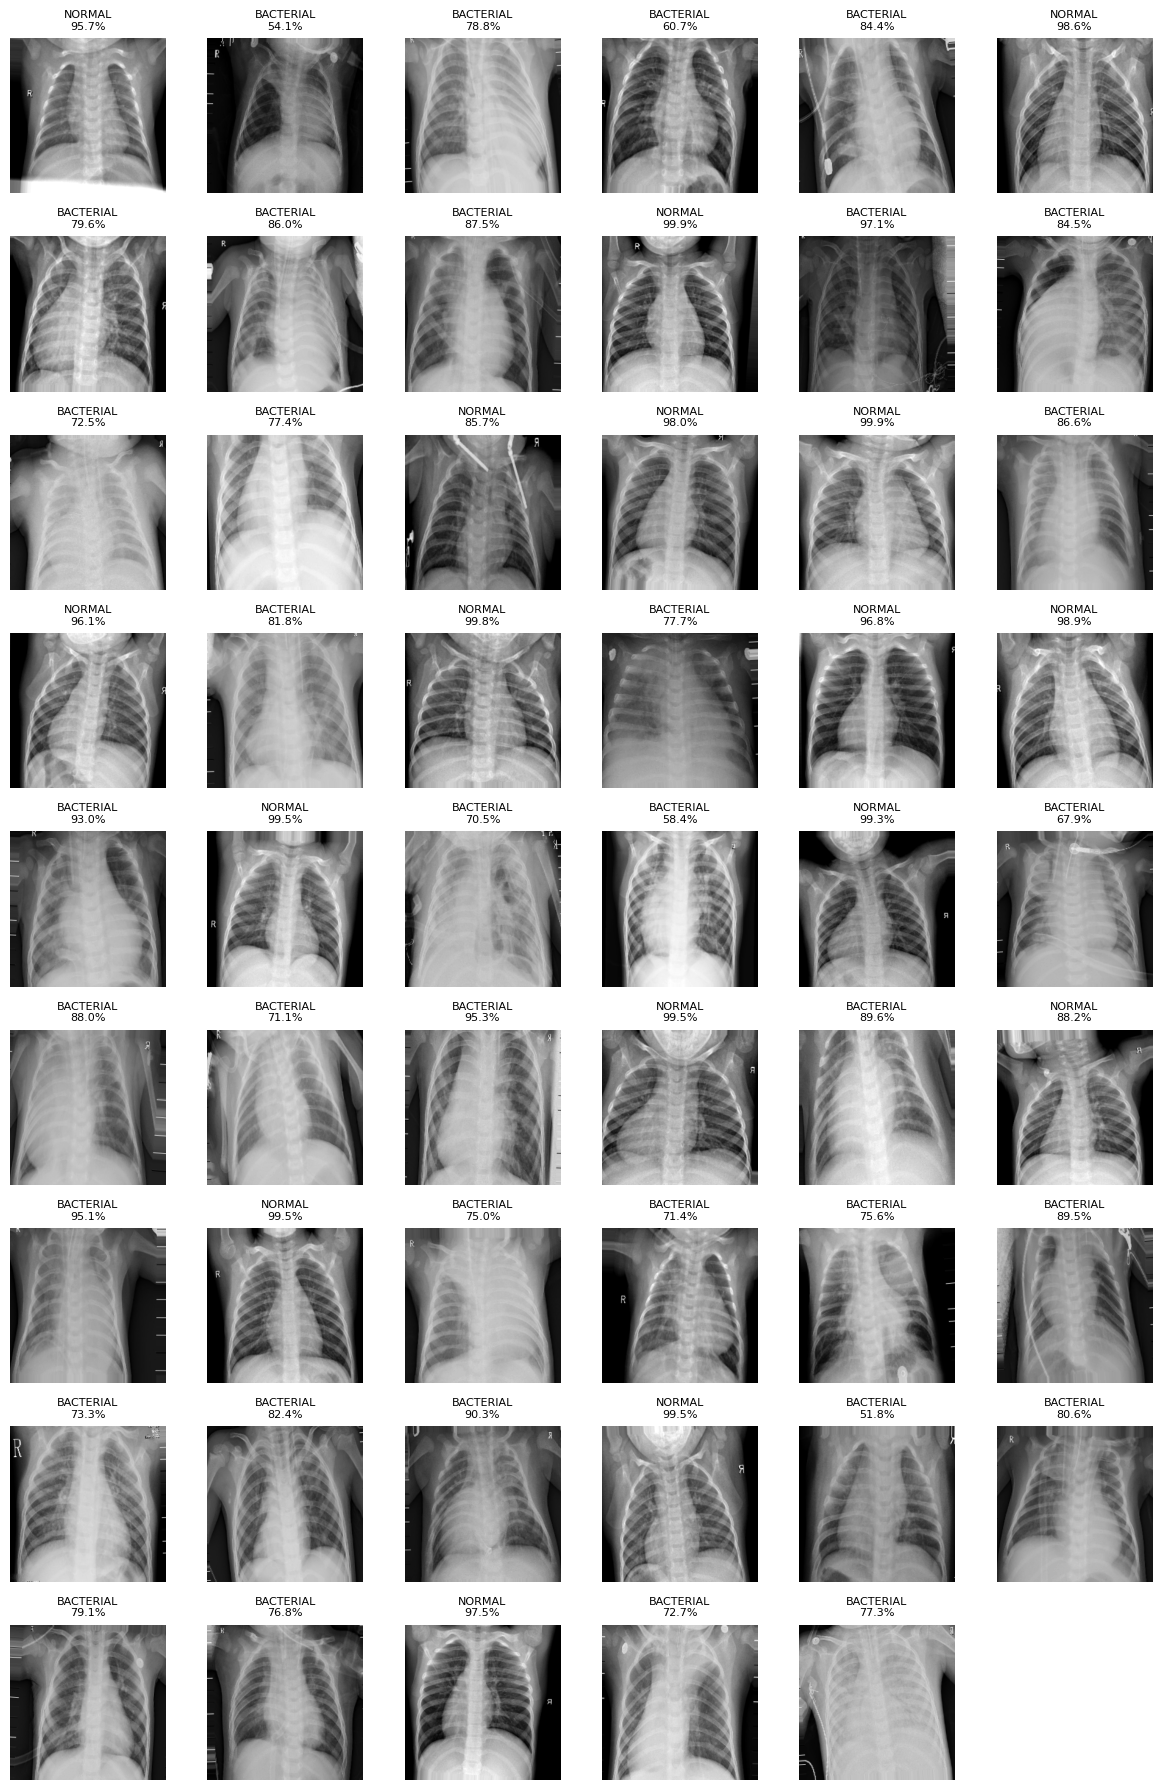

In [41]:
# Get one batch of training images and labels
images, labels = next(training_set)

# Limit to N images to show
N = 53
fig = plt.figure(figsize=(12, 18))

for i in range(min(N, images.shape[0])):
    ax = fig.add_subplot(9, 6, i+1)

    # Prepare image for prediction
    img = images[i]
    img_input = img.reshape(1, INPUT_SIZE, INPUT_SIZE, 1)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_input, verbose=0)
    predicted_class_index = np.argmax(prediction)
    confidence = np.max(prediction) * 100

    # Get predicted label name
    
    predicted_label = classes[predicted_class_index]

    # Show image with predicted label
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"{predicted_label}\n{confidence:.1f}%", fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()
